In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
sns.set(style='ticks', font_scale=1.5)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

vol_file = Path('depreciated/analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

### High-low gain activity in swim bouts

In [3]:
row_ = -1
is_plot = False
for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    row_ = row_+1
    if 'Optovin' not in row['task']:
        continue
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2+l_swim**2)
    
    task_period = frame_stimParams[2,swim_starts] # 1, low; 2 high
    task_period = task_period + frame_stimParams[3,swim_starts]*2 -2 # 
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    for n_ in range(len(swim_starts)):
        if (swim_starts[n_]>opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]>opto_t][-1]<10*300:
            task_period[n_] = task_period[n_] + 2
        if (swim_starts[n_]<opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]<opto_t][0]>-300:
            task_period[n_] = 0
    
    count_, _ = np.histogram(task_period, bins=range(8))
    if count_[1]<100:
        continue
    if not is_plot:
        continue
    
    plt.bar(np.arange(6)+1, count_[1:])
    plt.title([f'{folder}/{fish}', row_])
    # plt.title(f'fish index {row_}')
    plt.show()
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    for n_ in range(2):
        ax[n_].plot(np.arange(300)/300-50/300, visu[task_period==n_+1].mean(axis=0))
        ax[n_].plot(np.arange(300)/300-50/300, visu[task_period==n_+3].mean(axis=0))
        ax[n_].plot(np.arange(300)/300-50/300, visu[task_period==n_+5].mean(axis=0))
        ax[n_].set_xlim([-0.2, 0.8])
    
    for n_ in range(2):
        ax[n_+2].plot(np.arange(300)/300-50/300, p_swim[task_period==n_+1].mean(axis=0))
        ax[n_+2].plot(np.arange(300)/300-50/300, p_swim[task_period==n_+3].mean(axis=0))
        ax[n_+2].plot(np.arange(300)/300-50/300, p_swim[task_period==n_+5].mean(axis=0))
        ax[n_+2].set_xlim([-0.2, 0.8])
    plt.show()

### Swim trace by task epochs
* Find the fish with strong response after optovin application

In [4]:
is_plot = False

for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']

    if 'Optovin' not in row['task']:
        continue
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
    
#     swimdata = np.load(swim_dir/"swimdata.npy")[()]
#     r_swim = np.maximum(swimdata['fltCh1']-swimdata['back1'],0)
#     l_swim = np.maximum(swimdata['fltCh2']-swimdata['back2'],0)
#     p_swim = np.sqrt(r_swim+l_swim)
    
    p_swim = frame_swim_tcourse[0]
    
    
    gain_ = frame_stimParams[2]
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    opto_epoch = frame_stimParams[3]
    trial_ = frame_stimParams[4]
    num_trial = trial_.max().astype('int')-1
    p_swim = p_swim[:len(trial_)]*100
    
    p_swim_list = []
    
    for ntrial in range(num_trial):
        p_swim_list.append(p_swim[trial_==ntrial+1])
        trial_len = min([_.shape for _ in p_swim_list])[0]
        p_swim_list_ = np.vstack([_[:trial_len] for _ in p_swim_list])
        ave_ = p_swim_list_.mean(axis=0)
        epoch_len = trial_len//4
        labels = ['low', 'high', 'low+optv', 'high+optv']

    if not is_plot:
        continue
    
    for n_epoch in range(4):
        ave_smooth = smooth(ave_[n_epoch*epoch_len:(n_epoch+1)*epoch_len], k_)*300
        plt.plot(np.arange(epoch_len)/300, ave_smooth+4*n_epoch, label=labels[n_epoch])
    
    plt.vlines([10], [0], [16], linestyles='--', color='k')
    plt.xlim([0, epoch_len/300])
    sns.despine()
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3)
    plt.show()

#### Find the first swim bout power after optovin application

In [5]:
row_ = -1
is_plot = False
for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    row_ = row_+1
    if 'Optovin' not in row['task']:
        continue
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2+l_swim**2)
    
    task_period = frame_stimParams[2,swim_starts] # 1, low; 2 high
    task_period = task_period + frame_stimParams[3,swim_starts]*2 -2 # 
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    for n_ in range(len(swim_starts)):
        if (swim_starts[n_]>opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]>opto_t][-1]<10*300:
            task_period[n_] = task_period[n_] + 2
        if (swim_starts[n_]<opto_t).sum() == 0:
            continue
#         if swim_starts[n_] - opto_t[swim_starts[n_]<opto_t][0]>-300:
#             task_period[n_] = 0
    
    win_size = 2
    first_swim_bout_index = [np.where((task_period[:-1]!=5) & (task_period[1:]==5))[0]+1]
    first_swim_bout_index.append(np.where((task_period[:-1]!=6) & (task_period[1:]==6))[0]+1)
#     if len(first_swim_bout_index[0])==0:
#         break
    
    if win_size > 1:
        first_swim_bout_index[0] = np.concatenate([first_swim_bout_index[0]+_ for _ in range(win_size)])
        first_swim_bout_index[0] = first_swim_bout_index[0][first_swim_bout_index[0]<len(task_period)]
        first_swim_bout_index[1] = np.concatenate([first_swim_bout_index[1]+_ for _ in range(win_size)])
        first_swim_bout_index[1] = first_swim_bout_index[1][first_swim_bout_index[1]<len(task_period)]
    
    for clip_index in first_swim_bout_index:
        task_period[clip_index] = 0
    
    count_, _ = np.histogram(task_period, bins=range(8))
    if count_[1]<100:
        continue
    if not is_plot:
        continue

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))    
    titles = ['low gain', 'high gain']
    for n_ in range(2):
        ax[n_].plot(np.arange(300)/300-50/300, p_swim[task_period==n_+1].mean(axis=0), '-m', label='no opto')
        ax[n_].plot(np.arange(300)/300-50/300, p_swim[task_period==n_+3].mean(axis=0), '-b', label='before opto')
#         ax[n_].plot(np.arange(300)/300-50/300, p_swim[task_period==n_+5].mean(axis=0), '-r', label=f'after opto >{win_size} bouts')
#         ax[n_].plot(np.arange(300)/300-50/300, p_swim[first_swim_bout_index[n_]].mean(axis=0), '-k', label=f'after opto <{win_size} bouts')
        ax[n_].set_xlim([-0.2, 0.8])
        ax[n_].set_title(titles[n_])
        sns.despine()
    plt.legend()
    plt.show()

In [6]:
swim_power_list = []
swim_len_list = []
for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    row_ = row_+1
    if 'Optovin' not in row['task']:
        continue
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2+l_swim**2).sum(axis=-1)
    len_swim = (swim_ends - swim_starts)/300
    p_swim = p_swim/(len_swim*300)
    
    task_period = frame_stimParams[2,swim_starts] # 1, low; 2 high
    task_period = task_period + frame_stimParams[3,swim_starts]*2 -2 # 
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    for n_ in range(len(swim_starts)):
        if (swim_starts[n_]>opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]>opto_t][-1]<10*300:
            task_period[n_] = task_period[n_] + 2
        if (swim_starts[n_]<opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]<opto_t][0]>-300:
            task_period[n_] = 0
    
    win_size = 3
    first_swim_bout_index = [np.where((task_period[:-1]!=5) & (task_period[1:]==5))[0]+1]
    first_swim_bout_index.append(np.where((task_period[:-1]!=6) & (task_period[1:]==6))[0]+1)
    
    if win_size > 1:
        first_swim_bout_index[0] = np.concatenate([first_swim_bout_index[0]+_ for _ in range(win_size)])
        first_swim_bout_index[0] = first_swim_bout_index[0][first_swim_bout_index[0]<len(task_period)]
        first_swim_bout_index[1] = np.concatenate([first_swim_bout_index[1]+_ for _ in range(win_size)])
        first_swim_bout_index[1] = first_swim_bout_index[1][first_swim_bout_index[1]<len(task_period)]
    
    for clip_index in first_swim_bout_index:
        task_period[clip_index] = 0
    
    count_, _ = np.histogram(task_period, bins=range(8))
    if count_[1]<100:
        n_list = [np.nan] *8
        swim_power_list.append(n_list)
        swim_len_list.append(n_list)
        continue
        
    n_list = []
    for n_ in range(2):
        n_list.append(p_swim[task_period==n_+1].mean(axis=0))
        n_list.append(p_swim[task_period==n_+3].mean(axis=0))
        n_list.append(p_swim[first_swim_bout_index[n_]].mean(axis=0))
        n_list.append(p_swim[task_period==n_+5].mean(axis=0))
        
        
    swim_power_list.append(n_list)
    
    n_list = []
    for n_ in range(2):
        n_list.append(len_swim[task_period==n_+1].mean(axis=0))
        n_list.append(len_swim[task_period==n_+3].mean(axis=0))
        n_list.append(len_swim[first_swim_bout_index[n_]].mean(axis=0))
        n_list.append(len_swim[task_period==n_+5].mean(axis=0))
        
        
    swim_len_list.append(n_list)

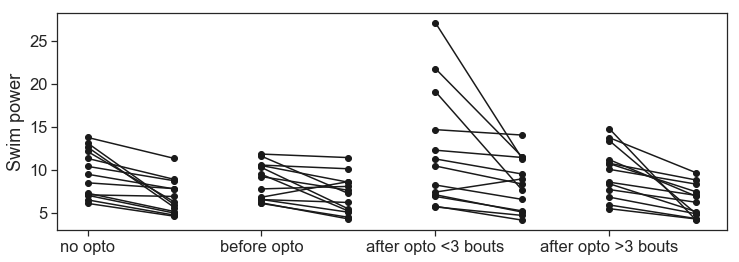

In [7]:
swim_power_list_ = np.array(swim_power_list)
plt.figure(figsize=(12, 4))
for n_ in range(4):
    plt.plot(np.arange(2)+n_*2, swim_power_list_[:, [n_, n_+4]].T, '-ok')
plt.xticks(np.arange(0,8,2), ['no opto', 'before opto', f'after opto <{win_size} bouts', f'after opto >{win_size} bouts'])
plt.ylabel('Swim power')
plt.show()

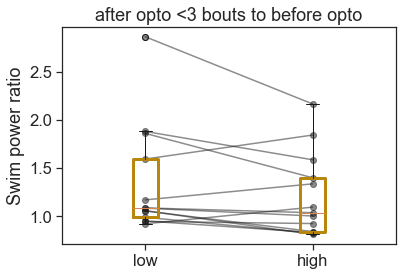

In [8]:
plt.plot(np.arange(1, 3), [(swim_power_list_[:, 2]/swim_power_list_[:, 1]), (swim_power_list_[:, 6]/swim_power_list_[:, 5])], '-ok', alpha=0.5)
boxprops = dict(linewidth=3, color='darkgoldenrod')
valid = ~np.isnan(swim_power_list_[:, 0])
plt.boxplot([(swim_power_list_[valid, 2]/swim_power_list_[valid, 1]), (swim_power_list_[valid, 6]/swim_power_list_[valid, 5])], boxprops=boxprops)
plt.ylabel('Swim power ratio')
plt.title(f'after opto <{win_size} bouts to before opto')
plt.xticks(np.arange(1, 3), ['low', 'high'])
plt.show()

In [9]:
opto_xls_file = dat_xls_file[dat_xls_file['task'].str.contains("Optovin")]
opto_xls_file = opto_xls_file.iloc[(swim_power_list_[:, 6]/swim_power_list_[:, 5]>1) & (swim_power_list_[:, 2]/swim_power_list_[:, 1]>1)]

/groups/ahrens/home/weiz/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [10]:
opto_xls_file.to_csv('depreciated/analysis_opto_based_on_swim_pattern.csv')

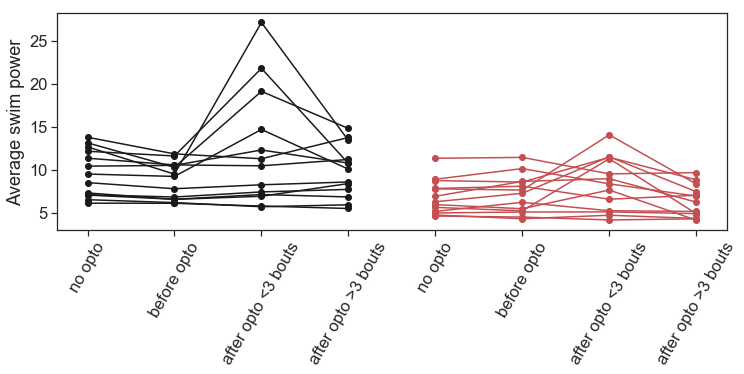

In [11]:
plt.figure(figsize=(12, 4))
c = ['k', 'r']
labels = ['low gain', 'high gain']
for n_ in range(2):
    plt.plot(np.arange(4)+n_*4, swim_power_list_[:, n_*4:n_*4+4].T, f'-o{c[n_]}', label=labels[n_])
plt.xticks(np.arange(8), ['no opto', 'before opto', f'after opto <{win_size} bouts', f'after opto >{win_size} bouts']*2, rotation=60)
plt.ylabel('Average swim power')
plt.show()

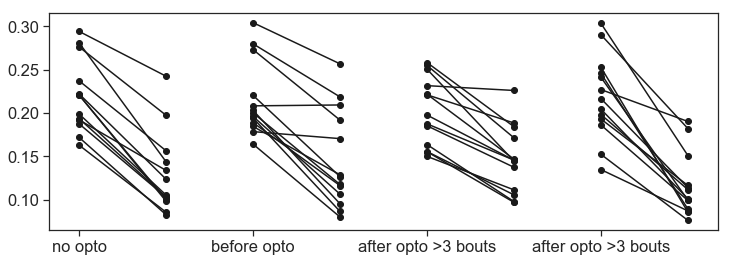

In [12]:
swim_len_list_ = np.array(swim_len_list)
plt.figure(figsize=(12, 4))
for n_ in range(4):
    plt.plot(np.arange(2)+n_*2, swim_len_list_[:, [n_, n_+4]].T, '-ok')
plt.xticks(np.arange(0,8,2), ['no opto', 'before opto', f'after opto >{win_size} bouts', f'after opto >{win_size} bouts'])
plt.show()

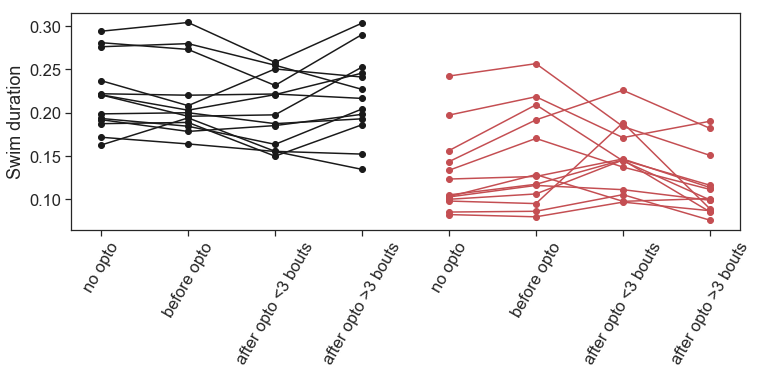

In [13]:
plt.figure(figsize=(12, 4))
c = ['k', 'r']
labels = ['low gain', 'high gain']
for n_ in range(2):
    plt.plot(np.arange(4)+n_*4, swim_len_list_[:, n_*4:n_*4+4].T, f'-o{c[n_]}', label=labels[n_])
plt.xticks(np.arange(8), ['no opto', 'before opto', f'after opto <{win_size} bouts', f'after opto >{win_size} bouts']*2, rotation=60)
plt.ylabel('Swim duration')
plt.show()